In [145]:
def bin2int(x):
    y = 0
    for i,j in enumerate(x):
        y += j<<i
    return y

import matplotlib.pyplot as plt
import numpy as np

def imshow_(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    
    plt.show()

def showdata_(dataloader):

    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    imshow_(torchvision.utils.make_grid(images))
    classelabel = [[] for i in range(batch_size)]
    for z, i in enumerate(labels.numpy()):
        tmp = []
        for idx, j in enumerate(i):
            if int(j)==True:
                tmp.append(idx)
        classelabel[z] = tmp
        
    classes = ('Bearing','CoverPlateTermina.','GussetPlateConnect.','OutOfPlaneStiffener')
    #labelClasse = [classes[idx] for idx in idxs]
    for i in range(batch_size):
        class_names = ' '.join(f'{classes[k]:5s}' for k in classelabel[i])
        print(f'Sample {i+1}: {class_names}', end='\t')

In [146]:
def plot_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        sample = dataset[i]
        image = sample[0].permute(1, 2, 0)  # Change dimensions for plotting
        label = sample[1]
        
        axes[i].imshow(image)
        axes[i].set_title(f'Label: {label.argmax().item()}')
        axes[i].axis('off')
    plt.show()

def plot_samples_(images, labels, predictions, classes):
    batch_size = len(images)
    fig, axes = plt.subplots(1, batch_size, figsize=(15, 15))
    for idx, (img, label, prediction) in enumerate(zip(images, labels, predictions)):
        axes[idx].imshow(img.permute(1, 2, 0))  # Convert CHW to HWC
        true_labels = ', '.join([classes[i] for i in range(len(classes)) if label[i] == 1])
        predicted_labels = ', '.join([classes[i] for i in range(len(classes)) if prediction[i] == 1])
        precision = [(label.astype(float), prediction.astype(float))]
        #axes[idx].set_title(f'True: {true_labels}\nPredicted: {predicted_labels}')
        axes[idx].axis('off')
        print('sample[',idx,']',precision,' : #True ',true_labels,'\t #predicted ',predicted_labels, end='\n')
        
    plt.show()


In [147]:
import os
import torch
import pandas as pd
from PIL import Image

class SteelDefectsDataset(Dataset):
    """steelDefects dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.defects_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.defects_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.defects_frame.iloc[idx, 0])
        image = Image.open(img_name)
        defects = self.defects_frame.iloc[idx, 1:]
        defects = torch.tensor(defects, dtype= torch.float32)
        
        if self.transform !=None:
            image = self.transform(image)

        return image, defects

In [148]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


trainpath = 'CocoBridgeMulticlass/train/'
testpath = 'CocoBridgeMulticlass/test/'
validpath = 'CocoBridgeMulticlass/valid/'

traincsvpath= 'CocoBridgeMulticlass/train/_classes.csv'
validcsvpath= 'CocoBridgeMulticlass/valid/_classes.csv'
testcsvpath = 'CocoBridgeMulticlass/test/_classes.csv'
# Hyperparameters
num_classes = 4
num_epochs = 5
learning_rate = 0.001
batch_size = 32

#normalize 
transform = transforms.Compose([transforms.Resize((256, 256)),
                                transforms.ToTensor(),
                                transforms.Normalize((.5,.5,.5),(.5,.5,.5))])

defects_Traindataset = SteelDefectsDataset(csv_file = traincsvpath, root_dir= trainpath, transform= transform)
trainloader = torch.utils.data.DataLoader(defects_Traindataset, batch_size = batch_size, shuffle=True)

defects_validdataset = SteelDefectsDataset(csv_file=validcsvpath, root_dir=validpath, transform=transform)
validloader = torch.utils.data.DataLoader(defects_validdataset, batch_size=batch_size, shuffle=False)

defects_Testdataset = SteelDefectsDataset(csv_file=testcsvpath, root_dir=testpath, transform=transform)
testloader = torch.utils.data.DataLoader(defects_Testdataset, batch_size=batch_size, shuffle=False)
#plot_samples(defects_Traindataset, num_samples=4)
#showdata_(trainloader)

In [149]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        padding = 0
        stride = 1
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5,stride=stride, padding=padding)#out 256-5+1 = 252 | pool: 126
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=stride, padding=padding)# out 126-5+1=122 | pool: 61
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=stride, padding=padding)# 61-3+1= 59 | pool = 29
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128*29*29, 512) #dense 1D layer
        self.fc2 =nn.Linear(512, num_classes)# output 4 classes
        self.dropout = nn.Dropout(0.5)# 
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = torch.flatten(x,1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x    

In [150]:
net = CNN(num_classes=num_classes)
import time
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
print(f'begin training for ',num_epochs ,end='\n')
for epoch in range(num_epochs):
    run_loss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):
        
        inputs, labels = data
        
        outputs = net(inputs)
        
        loss = criterion(outputs, labels.type_as(outputs))
        print('type:',type(labels), type(outputs), labels[1], outputs[1], end='\r')
        #backpropagation
        loss.backward()
        optimizer.step()
        run_loss+= loss.item()
        optimizer.zero_grad()
        
        if i%4 == 4:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {run_loss/len(trainloader):.4f}', end='\n')
            run_loss=0.0
    pathsave = 'G:/TrainedModels_tutos/SteelBridge_MLabelsClassification_B32.pth'
    torch.save(net.state_dict(), pathsave)

begin training for  5


In [151]:
path = 'G:/TrainedModels_tutos/SteelBridge_MLabelsClassification_B32.pth'
torch.save(net.state_dict(), path)

In [152]:
net = CNN(num_classes=num_classes)
net.load_state_dict(torch.load(path))

<All keys matched successfully>

In [153]:
# Evaluation
testloader = torch.utils.data.DataLoader(defects_Testdataset, batch_size=batch_size, shuffle=False)
def evaluate_model(dataloader):
    net.eval()  # Set the model to evaluation mode
    total, correct = 0, 0
    
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data#X, y
            outputs= torch.sigmoid(net(inputs)).numpy()
            predicted = (outputs>0.5).astype(int)
            #print(predicted[0], labels[0], outputs1[1])
            total += labels.size(0) * labels.size(1)
            #print(outputs, labels.size(0) , labels.size(1), labels.size(0) * labels.size(1))
            correct += (predicted == labels.numpy().astype(int)).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Accuracy of the network: {accuracy:.2f}%')
    
    net.train()  # Set the model back to training mode
evaluate_model(testloader)

Accuracy of the network: 79.78%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

sample[ 0 ] [(array([0., 1., 0., 0.]), array([0., 1., 0., 1.]))]  : #True  CoverPlateTermina. 	 #predicted  CoverPlateTermina., OutOfPlaneStiffener
sample[ 1 ] [(array([1., 0., 0., 1.]), array([1., 0., 0., 1.]))]  : #True  Bearing, OutOfPlaneStiffener 	 #predicted  Bearing, OutOfPlaneStiffener
sample[ 2 ] [(array([0., 1., 0., 0.]), array([1., 0., 0., 1.]))]  : #True  CoverPlateTermina. 	 #predicted  Bearing, OutOfPlaneStiffener
sample[ 3 ] [(array([0., 1., 0., 1.]), array([0., 0., 0., 1.]))]  : #True  CoverPlateTermina., OutOfPlaneStiffener 	 #predicted  OutOfPlaneStiffener
sample[ 4 ] [(array([1., 0., 0., 1.]), array([0., 0., 0., 1.]))]  : #True  Bearing, OutOfPlaneStiffener 	 #predicted  OutOfPlaneStiffener
sample[ 5 ] [(array([0., 1., 0., 1.]), array([0., 1., 0., 1.]))]  : #True  CoverPlateTermina., OutOfPlaneStiffener 	 #predicted  CoverPlateTermina., OutOfPlaneStiffener
sample[ 6 ] [(array([1., 0., 0., 1.]), array([1., 0., 0., 1.]))]  : #True  Bearing, OutOfPlaneStiffener 	 #predi

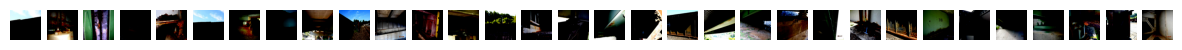

In [154]:
# Example usage to test the model on a batch of images from the dataloader
validloader = torch.utils.data.DataLoader(defects_validdataset, batch_size=batch_size, shuffle=True)
dataiter = iter(validloader)
images, labels = next(dataiter)
classes = ['Bearing','CoverPlateTermina.','GussetPlateConnect.','OutOfPlaneStiffener']

with torch.no_grad():
    outputs = net(images)
    predictions = torch.sigmoid(outputs).numpy()  # Apply sigmoid to get probabilities
    predictions = (predictions>.5).astype(int)

# Plot the batch of images with true labels and predicted labels
plot_samples_(images, labels.numpy(), predictions, classes)
